# Авиарейсы без потерь

В первый рабочий день новый начальник сообщает, что я — единственный аналитик филиала (а может, и всей Анапы). Мне торжественно вручили пропуск от личного кабинета и звание ведущего аналитика. И хоть мой офис больше похож на кладовку для швабр и в нём нет отопления, я чувствовал себя как большая шишка.

Я узнал, что компания переживает не лучшие времена каждую зиму: не все рейсы из Анапы окупаются в «низкий сезон». При этом есть направления, которые потенциально могут быть прибыльными, но у компании не хватает самолетов для их запуска. И моей первой задачей в новой должности стала помощь в поиске самых малоприбыльных рейсов.

## Цель проекта -

Региональное руководство не принимает решений об отмене рейсов, а только передаёт информацию о невыгодных перелетах в центральный филиал. Однако данных в компании накопилось столько, что никто не может вытащить из базы нужную информацию. Необходимо разобраться с базой и достать из неё нужные данные. А выводы затем предстоит представить перед высшим руководством.

## Задачи проекта -¶

1. Применить все базовые операторы SQL.
2. Поработать с базой данных, соединением и объединением таблиц.
3. Научиться самостоятельно подбирать данные для аналитической задачи.
4. Провести EDA по полученным данным.
5. Подготовить финансовую модель прибыльности авиарейсов.
6. Оформить итоговый доклад презентацией.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from itertools import combinations

# pd.set_option('display.max_rows', 50)  # показывать больше строк
# pd.set_option('display.max_columns', 50)  # показывать больше колонок

data = pd.read_csv('query.csv')

In [2]:
# строит столбчатые гистограммы
# с названием столбца в заголовке
# количество баров - количество уникальных значений в столбце
def bar_plot(column, data=data):
    data[column].plot(kind='hist', grid=True, title=str(
        column), bins=data[column].nunique())


# определим функцию для быстрого построения боксплотов по всему датасету
def get_boxplot(column1, column2, data=data):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column1, y=column2, data=data, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column2)
    plt.show()

In [3]:
# осмотрим набор данных
data.head()

,flight_id,s_dep,flight_month,flight_dom,flight_dow,s_arr,city_arr,model,fuel_consum_per_h,a_dep,...,seats_bus,total_seats_sold,revenue_eco,revenue_bus,revenue_total,flight_profit,flight_margin,profit_per_hour,profit_per_seat,profit_per_passenger
0,136698,2016-12-01T09:25:00Z,12.0,1.0,4.0,2016-12-01T10:15:00Z,Belgorod,Sukhoi Superjet-100,1700,2016-12-01T09:30:00Z,...,12,94,519600.0,226800.0,746400.0,5.070308e+05,0.679302,620854.081633,5227.121993,5393.945035
1,136187,2016-12-01T10:05:00Z,12.0,1.0,4.0,2016-12-01T11:45:00Z,Moscow,Boeing 737-300,2400,2016-12-01T10:09:00Z,...,12,129,1434600.0,439200.0,1873800.0,1.424125e+06,0.760020,854475.000000,10954.807692,11039.728682
2,136774,2016-12-02T09:25:00Z,12.0,2.0,5.0,2016-12-02T10:15:00Z,Belgorod,Sukhoi Superjet-100,1700,2016-12-02T09:27:00Z,...,12,93,513300.0,226800.0,740100.0,5.001792e+05,0.675826,600215.000000,5156.486254,5378.270609
3,136474,2016-12-02T10:05:00Z,12.0,2.0,5.0,2016-12-02T11:45:00Z,Moscow,Boeing 737-300,2400,2016-12-02T10:06:00Z,...,12,130,1446800.0,439200.0,1886000.0,1.438840e+06,0.762906,880922.448980,11068.000000,11068.000000
4,136873,2016-12-03T09:25:00Z,12.0,3.0,6.0,2016-12-03T10:15:00Z,Belgorod,Sukhoi Superjet-100,1700,2016-12-03T09:26:00Z,...,12,96,532200.0,226800.0,759000.0,5.164275e+05,0.680405,607561.764706,5323.994845,5379.453125


> Из условия задачи:  
> Ваш датасет должен обязательно включать id рейса и города вылета (Анапа) и прилета. Он также может включать такие данные, как модель самолёта и его характеристики, суммарную стоимость всех билетов на рейсе, затраченное время в полёте и прочее — на ваше усмотрение.

Поскольку все рейсы осуществляются из одного аэропорта г. Анапы, в датасете, который применяется в EDA, отсутствует столбец с аэропортом/городом вылета - данные столбцы содержат по одному единственному уникальному значению.

In [4]:
# изучим, какие данные (и какого типа эти данные) входят в датасет
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   flight_id             193 non-null    int64  
 1   s_dep                 193 non-null    object 
 2   flight_month          193 non-null    float64
 3   flight_dom            193 non-null    float64
 4   flight_dow            193 non-null    float64
 5   s_arr                 193 non-null    object 
 6   city_arr              193 non-null    object 
 7   model                 193 non-null    object 
 8   fuel_consum_per_h     193 non-null    int64  
 9   a_dep                 193 non-null    object 
 10  a_arr                 193 non-null    object 
 11  delay_dep_mins        193 non-null    float64
 12  delay_arr_mins        193 non-null    float64
 13  flight_time_h         193 non-null    float64
 14  fuel_cost             193 non-null    float64
 15  lease_pay             1

В наборе данных - информация о 193 рейсах, совершенных из аэропорта Анапы.

## Переменные

1. flight_id - номер рейса в базе;
2. s_dep - плановая дата и время вылета;
3. flight_month - месяц из плановой даты вылета;
4. flight_dom - день месяца из плановой даты вылета;
5. flight_dow - день недели из плановой даты вылета;
6. s_arr - плановая дата и время прилета в пункт назначения;
7. city_arr - пункт назначения (город);
8. model - модель самолета;
9. fuel_consum_per_h - расход топлива в час для модели самолета;
10. a_dep - реальная дата и время вылета;
11. a_arr - реальная дата и время прилета;
12. delay_dep_mins - задержка вылета (минуты);
13. delay_arr_mins - задержка прилета (минуты);
14. flight_time_h - время полета (час);
15. fuel_cost - стоимость топлива, затраченного на рейс;
16. lease_pay - лизинговые платежи в пересчете на один рейс;
17. salary - зарплата бортового состава в пересчете на один рейс;
18. food_cost - стоимость питания для пассажиров рейса;
19. total_seats - общее число мест в самолете;
20. seats_eco - число мест в эконом-классе;
21. seats_bus - число мест в бизнес-классе;
22. total_seats_sold - общее количество проданных билетов на рейс;
23. revenue_eco - выручка рейса с пассажиров эконом-класса;
24. revenue_bus - выручка рейса с пассажиров бизнес-класса;
25. revenue_total - выручка рейса;
26. flight_profit - прибыль рейса (выручка за вычетом расходов);
27. flight_margin - рентабельность рейса (отношение прибыли к выручке);
28. profit_per_hour - прибыль в пересчете на 1 час полета;
39. profit_per_seat - прибыль в пересчете на 1 посадочное место;
30. profit_per_passenger - прибыль в пересчете на 1 пассажира.

In [5]:
# добавим переменные, характеризующие заполняемость салона самолета:
data['revenue_eco_p'] = data['revenue_eco'] / data['revenue_total']
data['revenue_bus_p'] = data['revenue_bus'] / data['revenue_total']
data['seats_sold_percent'] = data['total_seats_sold'] / data['total_seats']

# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   flight_id             193 non-null    int64  
 1   s_dep                 193 non-null    object 
 2   flight_month          193 non-null    float64
 3   flight_dom            193 non-null    float64
 4   flight_dow            193 non-null    float64
 5   s_arr                 193 non-null    object 
 6   city_arr              193 non-null    object 
 7   model                 193 non-null    object 
 8   fuel_consum_per_h     193 non-null    int64  
 9   a_dep                 193 non-null    object 
 10  a_arr                 193 non-null    object 
 11  delay_dep_mins        193 non-null    float64
 12  delay_arr_mins        193 non-null    float64
 13  flight_time_h         193 non-null    float64
 14  fuel_cost             193 non-null    float64
 15  lease_pay             1

## s_dep - плановая дата и время вылета

В датасете - рейсы за зимний сезон (с 1 декабря 2016 года по 28 февраля 2017 года). По условию задачи предлагалось взять рейсы за декабрь 2017 года вместо 2016 года, но таковых в предложенной для анализа базе данных не оказалось. Тема поднималась для обсуждения в Slack.

In [6]:
display(data.s_dep.min())
display(data.s_dep.max())

'2016-12-01T09:25:00Z'

'2017-02-28T10:05:00Z'

## flight_month - месяц из плановой даты вылета

Рейсы равномерно распределены по месяцам. В феврале на три календарных дня меньше - количество рейсов меньше на 6 и 7 соответственно по сравнению с декабрем и январем.

In [7]:
data.flight_month.value_counts()

1.0     67
12.0    66
2.0     60
Name: flight_month, dtype: int64

## flight_dom - день месяца из плановой даты вылета

Рейсы регулярные и равномерно распределены по всему календарному месяцу.

In [8]:
data.flight_dom.value_counts()

6.0     7
21.0    7
14.0    7
10.0    7
17.0    7
7.0     7
20.0    7
13.0    7
24.0    7
3.0     7
27.0    7
28.0    7
5.0     6
11.0    6
4.0     6
8.0     6
9.0     6
2.0     6
16.0    6
1.0     6
12.0    6
15.0    6
18.0    6
19.0    6
22.0    6
23.0    6
25.0    6
26.0    6
31.0    5
30.0    4
29.0    4
Name: flight_dom, dtype: int64

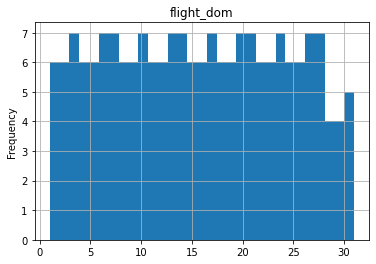

In [9]:
bar_plot('flight_dom')

## flight_dow - день недели из плановой даты вылета

Распределение по дням недели хоть и равномерно (как и распределением по дням месяца), но выделяется вторник - количетсо рейсов в этот день на 13 больше, чем в остальные дни.

In [10]:
data.flight_dow.value_counts()

2.0    39
1.0    26
0.0    26
6.0    26
5.0    26
4.0    26
3.0    24
Name: flight_dow, dtype: int64

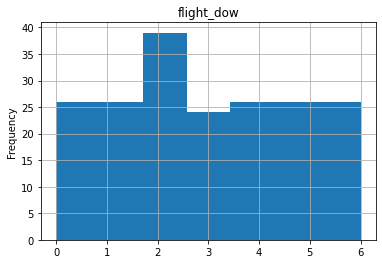

In [11]:
bar_plot('flight_dow')

## city_arr - пункт назначения (город)

Из количество рейсов в разрезе городов делаем вывод: рейсы из Анапы в Москву и Белгород осуществляются ежедневно, рейс в Новокузнецк - еженедельно.

In [12]:
data.city_arr.value_counts()

Moscow          90
Belgorod        90
Novokuznetsk    13
Name: city_arr, dtype: int64

## model - модель самолета

Рейсы из Анапы за анализируемый период осуществлются на двух моделях самолетов - Boeing 737-300, Sukhoi Superjet-100. При этом "Боинг" используется на рейсах до Москвы и Новокузнецка, "Сухой" - на рейсах до Белгорода.

In [13]:
data.model.value_counts()

Boeing 737-300         103
Sukhoi Superjet-100     90
Name: model, dtype: int64

## fuel_consum_per_h - расход топлива в час для модели самолета

Самолеты заправляются реактивным топливом. Оно везде одинаковое. Во всем мире называется JET-A. В России ТС-1 или РТ (Реактивное Топливо). Стоимость расчета полета каждого рейса во всем мире делается делается компаниями SITA (https://www.sita.aero) и JEPPESSEN (https://ww2.jeppesen.com). Возможно есть и другие, но упомянуты не были. Стоимость расчета каждого отдельного рейса обходится А/К в 10$ (не учтено в модели).

Если самолет вылетает из точки А в точку Б. При этом в точке Б стоимость тонны топлива сильно дороже (в 1.5-2 раза) чем в точке А. В этом случае в самолет может быть погружено топливо на обратную дорогу и залито в точке Б (в настоящей модели используется допущение, что самолеты заправляются в Анапе - аэропорту вылета).

У каждого судна есть свой Среднечасовой Расход Топлива.

В реальной авиации также используются следующие показатели для расчета прибыльности вылетов, но в имеющейся модели не были использованы в силу необходимости привлекать экспертов и сведения, которые отсутствовали в предложенной для анализа базе данных:
* DOW - Dry Open Weight - Вес судна без пассажиров и багажа (кг)
* PLD - Pay Load - вес пассажиров с багажом (кг)
* ETOW - Estimated Takeover Weight - расчетный взлетный вес (кг)
* ELDW - Estimated Landing Weight - расчетный вес при посадке (с учетом расходованного топлива)
* Total Reserves - Резерв топлива сверх полетного (на полтора часа кружения, если нужно будет уйти на второй круг и ждать очереди на посадку)
* Fuel on Board - топливо всего

О времени полетов из Анапы:
       до Москвы - 2ч, https://www.aborigen-tour.ru/book/russia/anapa/how-to-fly-to-anapa-from-moscow.php
       до Белгорода - 1ч, https://www.aborigen-tour.ru/book/russia/anapa/how-to-fly-to-anapa-from-belgorod.php
       до Новокузнецка - 5ч, https://www.aborigen-tour.ru/book/russia/anapa/how-to-fly-to-anapa-from-novokuznetsk.php

       Время полетов нам понадобиться для оценки стоимости топлива на рейс
       Возможно расчитать расход топлива и по расстоянию, но
       расстояние можно ввести либо "словарем",
       либо посчитать по тригонометрической формуле, что довольно трудоемкая задача;
       формула для расчета - http://www.gps-forum.ru/forum/viewtopic.php?t=29539#p163274

       (для трех направлений это еще допустимо;
       при этом, в отличие от времени полета, у нас не будет дифференциации между рейсами)
       
О расходе топлива самолетов:
       Sukhoi Superjet-100 = 1700 кг/ч
       Boeing 737-300 = 2400 кг/ч
       http://newsruss.ru/doc/index.php/Расход_топлива_у_самолётов

## delay_dep_mins - задержка вылета (минуты)

В целом, расписание вылетов соблюдается. Сраднее время задержки рейса при вылете - 3.5 минуты. Медиана - 3 минуты. 11 самолетов вылетели из Анапы ровно в назначенное время. Всего в 4 рейсах из 193 задержка вылета составила 10 минут и более. Максимальное опоздание - 42 минуты.

Расписание соблюдалось более качественно в декабре, если говорить о месяцах; в субботу - если говорить о днях недели.

Задержки при вылетах рейсов не оказывают влияния на прибыльность рейсов.

In [14]:
data.delay_dep_mins.describe()

count    193.000000
mean       3.538860
std        4.693723
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       42.000000
Name: delay_dep_mins, dtype: float64

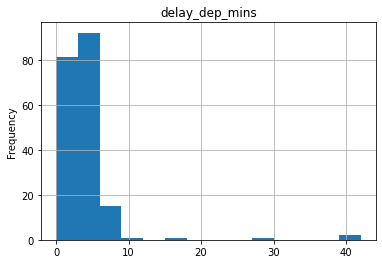

In [15]:
bar_plot('delay_dep_mins')

In [16]:
data['flight_id'][data.delay_dep_mins == 0].count()

11

In [17]:
data['flight_id'][data.delay_dep_mins > 10].count()

4

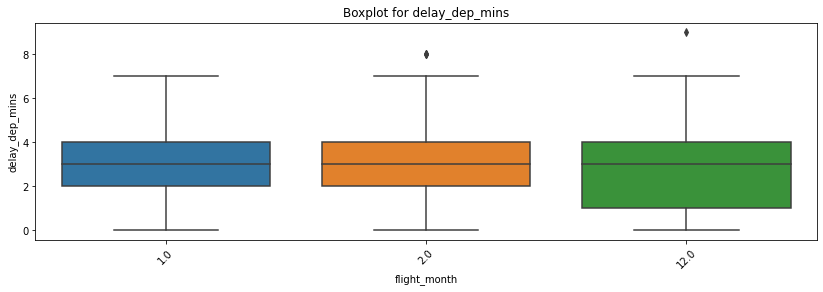

In [18]:
get_boxplot('flight_month', 'delay_dep_mins',
            data=data[data['delay_dep_mins'] <= 10])

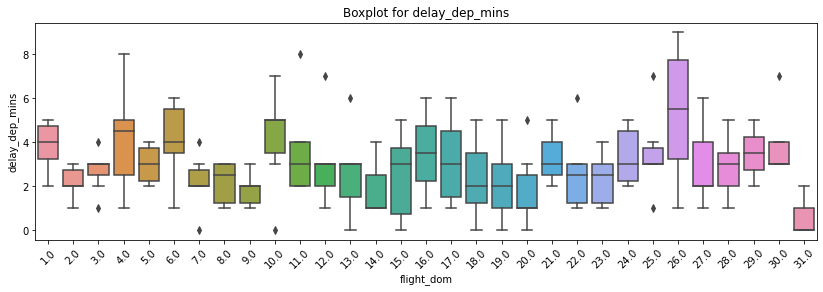

In [19]:
get_boxplot('flight_dom', 'delay_dep_mins',
            data=data[data['delay_dep_mins'] <= 10])

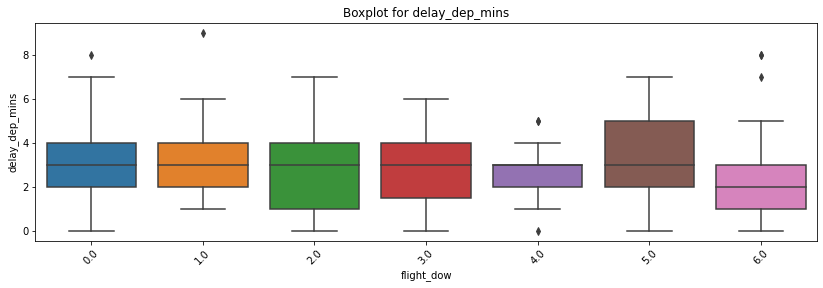

In [20]:
get_boxplot('flight_dow', 'delay_dep_mins',
            data=data[data['delay_dep_mins'] <= 10])

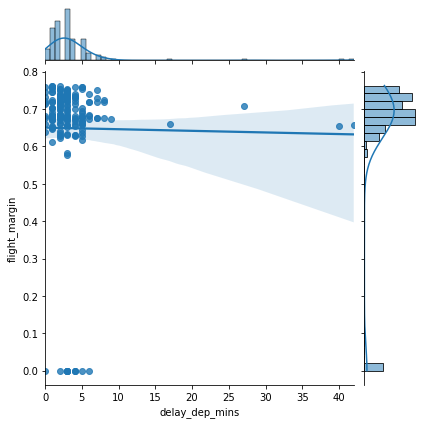

In [21]:
sns.jointplot(x='delay_dep_mins', y='flight_margin', data=data, kind='reg')

In [22]:
data[['delay_dep_mins', 'flight_margin']].corr()

,delay_dep_mins,flight_margin
delay_dep_mins,1.000000,-0.011342
flight_margin,-0.011342,1.000000


## delay_arr_mins - задержка прилета (минуты)

Как и задержки вылетов, задержки прилетов не оказывают влияния на прибыльность (рентабельность) рейсов.

In [23]:
data.delay_arr_mins.describe()

count    193.000000
mean       3.585492
std        4.863148
min       -2.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       42.000000
Name: delay_arr_mins, dtype: float64

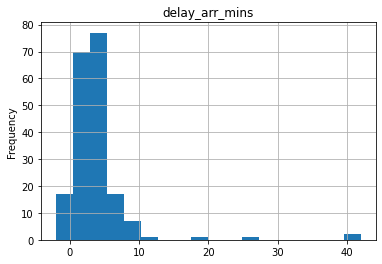

In [24]:
bar_plot('delay_arr_mins')

In [25]:
data[['delay_arr_mins', 'flight_margin']].corr()

,delay_arr_mins,flight_margin
delay_arr_mins,1.000000,-0.057124
flight_margin,-0.057124,1.000000


## flight_time_h - время полета (час)

Минимальное время полета - 0.82 часа (Анапа-Белгород), максимальное - 5.2 часа (Анапа-Новокузнецк).

Продолжительности рейсов по трем направлениям в целом распределены нормально и варьируются в следующих диапазонах: Анапа-Белгород от 0.82 до 0.85 часа, Анапа-Москва от 1.63 до 1.72 часа, Анапа-Новокузнецк от 4.98 до 5.2 часа (много рейсов с продолжительностью, близкой к максимальной).

In [26]:
data.flight_time_h.describe()

count    193.000000
mean       1.508981
std        1.047745
min        0.816667
25%        0.833333
50%        1.650000
75%        1.666667
max        5.200000
Name: flight_time_h, dtype: float64

In [27]:
flight_time_pivot = pd.pivot_table(data, values='flight_time_h', index=[
                                   'city_arr'], aggfunc=['min', 'max', 'median', 'mean'])

flight_time_pivot

,min,max,median,mean
,flight_time_h,flight_time_h,flight_time_h,flight_time_h
city_arr,,,,
Belgorod,0.816667,0.850000,0.833333,0.833519
Moscow,1.633333,1.716667,1.666667,1.666111
Novokuznetsk,4.983333,5.200000,5.083333,5.097436


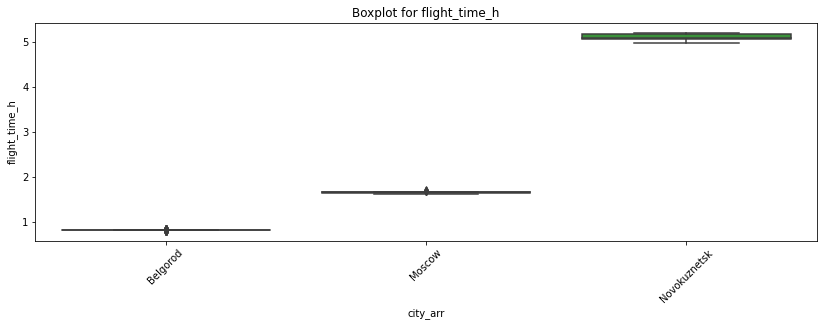

In [28]:
get_boxplot('city_arr', 'flight_time_h')

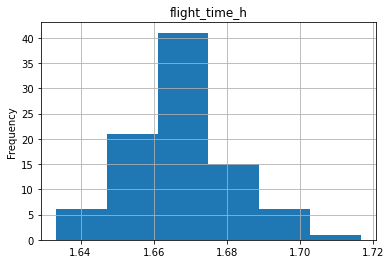

In [29]:
bar_plot('flight_time_h', data=data[data.city_arr == 'Moscow'])

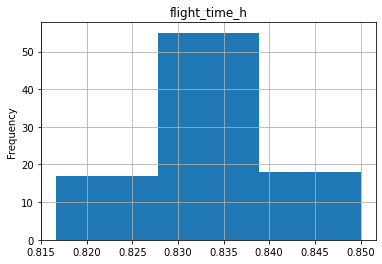

In [30]:
bar_plot('flight_time_h', data=data[data.city_arr == 'Belgorod'])

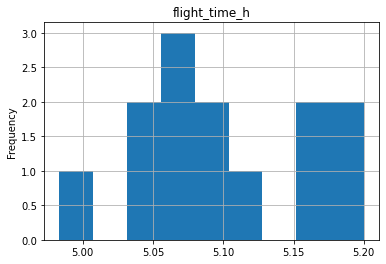

In [31]:
bar_plot('flight_time_h', data=data[data.city_arr == 'Novokuznetsk'])

## fuel_cost - стоимость топлива, затраченного на рейс

В предложенной модели расход топлива зависит от двух переменных - модели самолета и его расхода топлива в соответствии с документамией (fuel_consum_per_h) и продолжительностью полета.

Подробнее - см. раздел fuel_consum_per_h.

In [32]:
fuel_data = data[['fuel_consum_per_h', 'flight_time_h', 'fuel_cost']]
fuel_data.corr()

,fuel_consum_per_h,flight_time_h,fuel_cost
fuel_consum_per_h,1.000000,0.604194,0.668441
flight_time_h,0.604194,1.000000,0.995116
fuel_cost,0.668441,0.995116,1.000000


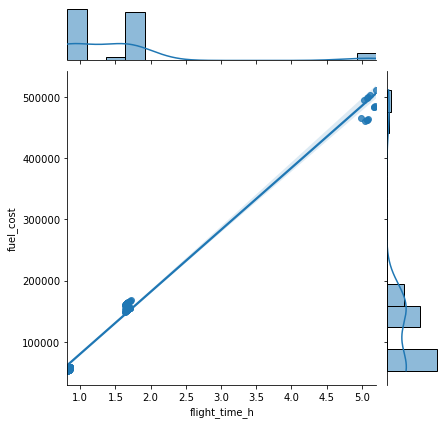

In [33]:
sns.jointplot(x='flight_time_h', y='fuel_cost', data=data, kind='reg')

## lease_pay - лизинговые платежи в пересчете на один рейс

У большинства авиакомпаний авиапарк в лизинге (т.е. каждый месяц авиакомпания платит за аренду самолета лизинговой компании). Стоимость зависит от условий и типа судна. Для расчета в рамках нашей модели воспользуемся поиском информации в открытых источниках о недавних сделках по интересующим нас моделям самолетов.

Боинг 737-300.
Удалось найти информации о сделке на 50 самолетов и 18 лет в 5542 млрд. долл.
Таким образом, можем найти "среднесуточную" плату за самолет ~ 1096000 руб./день.
Методика: Сумма по договору лизинга / кол-во самолетов по договору / срок договора (лет) / 365 дней * курс долл.

Дополнительно примем во внимание следующие допущения и скорректируем "среднесуточную" плату по лизингу на "длительность эксплуатации" самолета для совершения рейса:
							Рейс до Москвы из Анапы 2ч + обслуживание самолета в аэропорту 2ч = 1/6 суток
							182500 руб./рейс
							Рейс до Новокузнецка 5ч + обслуживание 3ч = 1/3 суток
							365300 руб./рейс
                            
Сухой СуперДжет-100.
Аналогичным образом поступим и со второй моделью самолетов с учетом, что была найдена информация о сделке, в рамках которой каждый самолет отдается в лизинг авиакомпании сроком на 12 лет за 52 млн. долл. (или 772000 рублей/сутки):
							Рейс до Белгорода 1ч + обслуживание 2ч = 1/8 суток
							96500 руб./рейс

Курс 65 руб./долл. 19 октября 2019 (Сухой)
Курс 32 руб./долл. 19 сентября 2013 (Боинг)
* Информация о сделках из 2013 и 2019 годов - соответственно, курсы валют не сопоставимые. Учтем курс доллара в обоих случаях по 2019 году. Информация о курсах валют - сайт ЦБ РФ.

Источники:
https://www.interfax.ru/aeroflot/679393  
https://www.interfax.ru/business/329949

Расчеты - в запросе:  
CASE  
    WHEN (a.model = 'Boeing 737-300'  
        AND arr_ap.city = 'Moscow') THEN 182500  
    WHEN (a.model = 'Boeing 737-300'  
        AND arr_ap.city = 'Novokuznetsk') THEN 365300  
    ELSE 96500  
END lease_pay

In [34]:
lease_pay_per_flight = pd.pivot_table(data, values='lease_pay', index=[
                                      'city_arr'], aggfunc=['mean'])

lease_pay_per_flight

,mean
,lease_pay
city_arr,
Belgorod,96500
Moscow,182500
Novokuznetsk,365300


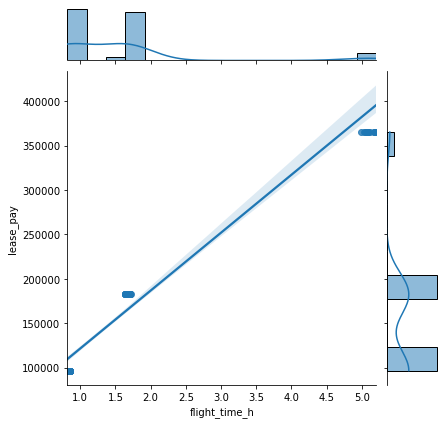

In [35]:
sns.jointplot(x='flight_time_h', y='lease_pay', data=data, kind='reg')

## salary - зарплата бортового состава в пересчете на один рейс

Пассажирские самолеты делятся на:
* ближнемагистральные (до 2500-3000км), -- Анапа-Белгород, Анапа-Москва
* среднемагистральные (от 3000-6000км) -- Анапа-Новокузнецк
* и дальнемагистральные (>6000км).

Бортпроводники на БМ и СМ: 4-6 человек. На ДМ: 7-12 человек.  
Плюс командир, плюс второй пилот, плюс иногда борт-инженер (каждый получает зарплату).  
Средняя зарплата бортпроводника 80-100 тыс.руб. Командира 350-500 тыс.руб.  
Второго пилота 200-300 тыс.руб. Борт-инженера 200-300 тыс.руб.  
Зарплаты учтем по нижней границе. На Москву и Белгород по 4 БП, Новокузнецк - 6 БП.

Допущение: рабочий день экипажа - 8 часов. Рабочих дней в месяце = 20.  
до Москвы 2ч + 2ч обслуживания = 1/2 рабочего дня;  
до Белгорода 1ч + 2ч обслуживания = 3/8 рабочего дня;  
до Новокузнецка 5ч + 3ч обслуживания = 1 рабочий день.

Расчеты - в запросе:  
CASE  
WHEN arr_ap.city = 'Moscow' THEN 0.5*(4*80000+350000+200000+200000)/20  
WHEN arr_ap.city = 'Belgorod' THEN 0.375*(4*80000+350000+200000+200000)/20  
ELSE (6*80000+350000+200000+200000)/20  
END AS salary

In [36]:
salary_per_flight = pd.pivot_table(data, values='salary', index=[
                                   'city_arr'], aggfunc=['mean'])

salary_per_flight

,mean
,salary
city_arr,
Belgorod,20062.5
Moscow,26750.0
Novokuznetsk,61500.0


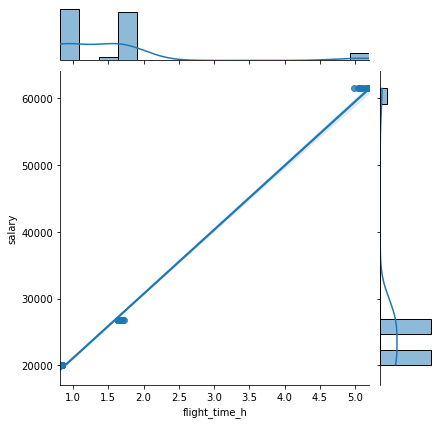

In [37]:
sns.jointplot(x='flight_time_h', y='salary', data=data, kind='reg')

## food_cost - стоимость питания для пассажиров рейса

Бортовое питание загружается либо туда-обратно, либо только туда, если срок годности истекает после прилета (на комбинате бортпитания еда готовится сразу к употреблению и подвергается шоковой заморозке; затем погружается в самолет; в самолетах нет холодильных камер - поэтому срок годности к употреблению сокращенный). 

В некоторых случаях авиакомпании покупает бортпитание на обратную дорогу в аэропорту обратного вылета.

В среднем, стоимость одного набора питания на пассажира 7-8 долларов для эконома, для бизнеса и первого класса 30-50 долларов.

Расходы на бортовое питание (допущения, используемые в расчетной модели):  
В среднем, стоимость одного набора питания на пассажира 7-8 долларов (525 рублей) для эконома,  
для бизнеса и первого класса 30-50 долларов (2250 рублей).  

Расчет для класса comfort не приводятся - в имеющихся на рассматриваемых рейсах самолетах билеты на такие места не продавались.

На рейсе до Новокузнецка питание не предоставляется (тезнический рейс - особенности рейса по данному маршруту будут рассмотрены ниже - см. раздел tickets_sold and revenue).

Расчеты - в запросе:  
CASE  
WHEN temp2.total_tickets_sold ISNULL THEN 0  
ELSE (525*temp2.tickets_sold_eco)+(2250*temp2.tickets_cold_bus)  
END AS food_cost

In [38]:
food_cost_per_flight = pd.pivot_table(data, values='food_cost', index=[
                                      'city_arr'], aggfunc=['mean'])

food_cost_per_flight

,mean
,food_cost
city_arr,
Belgorod,66617.500000
Moscow,77709.166667
Novokuznetsk,0.000000


## costs_total

city_arr
Belgorod        AxesSubplot(0.125,0.125;0.775x0.755)
Moscow          AxesSubplot(0.125,0.125;0.775x0.755)
Novokuznetsk    AxesSubplot(0.125,0.125;0.775x0.755)
Name: costs_total, dtype: object

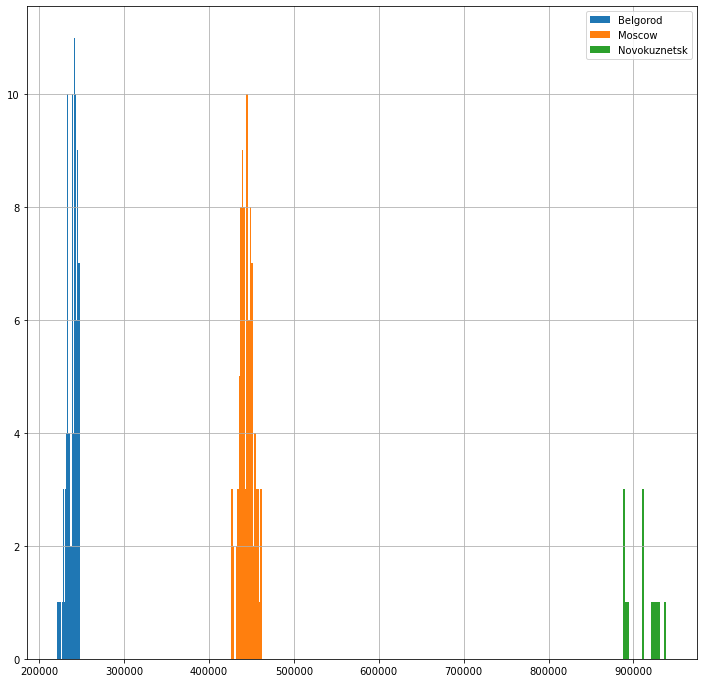

In [39]:
data['costs_total'] = data['fuel_cost'] + data['lease_pay'] + data['salary'] + data['food_cost']
data.groupby(by='city_arr')['costs_total'].hist(bins=20, legend=True, figsize=(12, 12))

## seats

Вместимость представленных в выборке самолетов (Боинг 737-300 и Сухой СуперДжет-100) - 130 и 97 пассажиров соответственно. При этом количество мест в бизнес-классе одинаково - таким образом, можем предположить, что далее, при анале выручки с рейса, мы увидим, что на рейсах, где применяется Сухой СуперДжет-100, доля выручки, которую приносят пассажиры бизнес-класса, окажется выше.

Также стоит отметить, что в базе данных имелись самолеты/рейсы с посадочными местами типа comfort - однако, в выборке таких нет и соответствующий столбец был опущен для сокращения размера таблицы выгрузки.

In [40]:
data.groupby('model')['total_seats'].mean()

model
Boeing 737-300         130
Sukhoi Superjet-100     97
Name: total_seats, dtype: int64

In [41]:
data.groupby('model')['seats_eco'].mean()

model
Boeing 737-300         118
Sukhoi Superjet-100     85
Name: seats_eco, dtype: int64

In [42]:
data.groupby('model')['seats_bus'].mean()

model
Boeing 737-300         12
Sukhoi Superjet-100    12
Name: seats_bus, dtype: int64

## tickets_sold and revenue

Первое, на что стоит обратить внимание - на рейсах Анапа-Новокузнецк нет ни одного проданого билета - ни один пассажир ни разу не воспользовался этим рейсом.

Всего в выгрузке 13 рейсов между этими городами. Полёт осуществляет Боинг 737-300, без пассажиров. Рейс осуществляется раз в неделю в 6:10 утра (scheduled).
Вот, что удалось найти в интернете по данному вопросу (при поддержке коллег из Slack):
«Существует такое понятие, как слот. Это время, выделенное в аэропорту определённому рейсу для прибытия или отправления самолёта. Слот платный и стоит несколько миллионов долларов. Если какое-то время авиакомпания не выполняет перелёты, место переходит к следующему перевозчику в листе ожидания. А значит, слот придётся покупать ещё раз, чего ни одна авиакомпания не хочет. Поэтому иногда им приходится совершать пустые рейсы, чтобы «налетать» норму — 80 % времени использования слота».

Будем иметь это ввиду при подведении итогов. В то же время, при дальнейшем анализе прибыльности рейсов стоит исключить рейсы Анапа-Новокузнецк из выборки и более детально рассмотреть два направления - Анапа-Москва и Анапа-Белгород.

Использование разных самолетов на рейсах в Москву и Белгород создает неравные условия для конкуренции в чистых продажах и выручке. Полеты в Москву с этой точки зрения оказываются более эффективными - ведь они приносят значительно больше денег. Так, например, самый "горячий" рейс до Белгорода принес компании 765,3 тыс. рублей, при этом самый "низкий" по выручке рейс до Москвы - 1372,4 тыс. рублей.

Разрыв в "весе" рейсов по принесенным деньгам особенно хорошо заметен на боксплотах.

Суммарная выручка со всех рейсов в Москву оказалась в 2.31 раза больше всей выручки рейсов Анапа-Белгород.

При оценке календарного распределения выручки отметим, что средний уровень выручки стабилен от месяца к месяцу. Такая же закономерность верна и для распределения выручки по дням месяца и дням недели - выделить какие-то дни, когда случаются особенно сильные или слабые результаты с точки зрения выручки.

Дополнительно была выдвинута гипотеза, что выручка от продажи билетов может быть как-то связана с задержками рейсов, но гипотеза не подтвердилась - корреляция отстуствует.

Мы не будем подробно останавливаться здесь на пересчете выручки на пассажиров или время полета - подобным вычислениям и анализу будет отведено время при оценке итоговой прибыльности рейсов.

In [43]:
display(data.groupby('city_arr')['total_seats_sold'].max())
display(data.groupby('city_arr')['total_seats_sold'].min())
display(data.groupby('city_arr')['total_seats_sold'].mean())
display(data.groupby('city_arr')['total_seats_sold'].median())

city_arr
Belgorod         97
Moscow          130
Novokuznetsk      0
Name: total_seats_sold, dtype: int64

city_arr
Belgorod        64
Moscow          92
Novokuznetsk     0
Name: total_seats_sold, dtype: int64

city_arr
Belgorod         90.455556
Moscow          113.444444
Novokuznetsk      0.000000
Name: total_seats_sold, dtype: float64

city_arr
Belgorod         94.0
Moscow          112.5
Novokuznetsk      0.0
Name: total_seats_sold, dtype: float64

In [44]:
i = data[(data.city_arr == 'Novokuznetsk')].index
data_part = data.drop(i)
data_part.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 192
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   flight_id             180 non-null    int64  
 1   s_dep                 180 non-null    object 
 2   flight_month          180 non-null    float64
 3   flight_dom            180 non-null    float64
 4   flight_dow            180 non-null    float64
 5   s_arr                 180 non-null    object 
 6   city_arr              180 non-null    object 
 7   model                 180 non-null    object 
 8   fuel_consum_per_h     180 non-null    int64  
 9   a_dep                 180 non-null    object 
 10  a_arr                 180 non-null    object 
 11  delay_dep_mins        180 non-null    float64
 12  delay_arr_mins        180 non-null    float64
 13  flight_time_h         180 non-null    float64
 14  fuel_cost             180 non-null    float64
 15  lease_pay             1

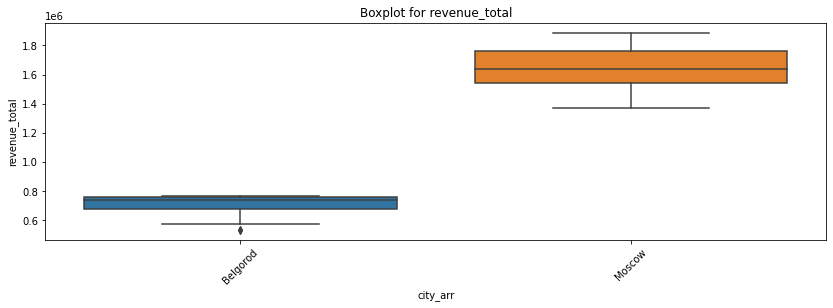

In [45]:
get_boxplot('city_arr', 'revenue_total', data=data_part)

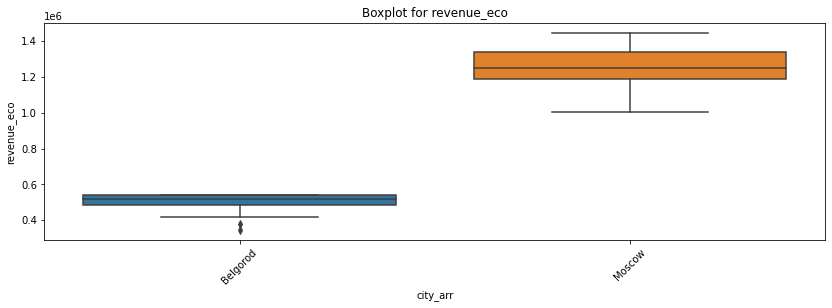

In [46]:
get_boxplot('city_arr', 'revenue_eco', data=data_part)

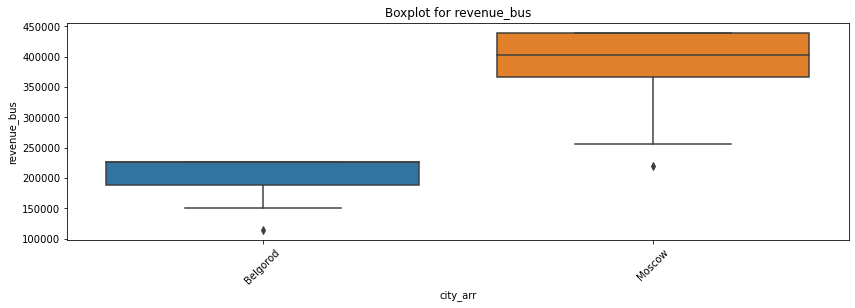

In [47]:
get_boxplot('city_arr', 'revenue_bus', data=data_part)

In [48]:
display(data_part.groupby('city_arr')['revenue_total'].max())
display(data_part.groupby('city_arr')['revenue_total'].min())
display(data_part.groupby('city_arr')['revenue_total'].median())

city_arr
Belgorod     765300.0
Moscow      1886000.0
Name: revenue_total, dtype: float64

city_arr
Belgorod     531000.0
Moscow      1372400.0
Name: revenue_total, dtype: float64

city_arr
Belgorod     736950.0
Moscow      1635300.0
Name: revenue_total, dtype: float64

In [49]:
data_part.groupby('city_arr')['revenue_total'].sum()[
    1] / data_part.groupby('city_arr')['revenue_total'].sum()[0]

2.311770751937513

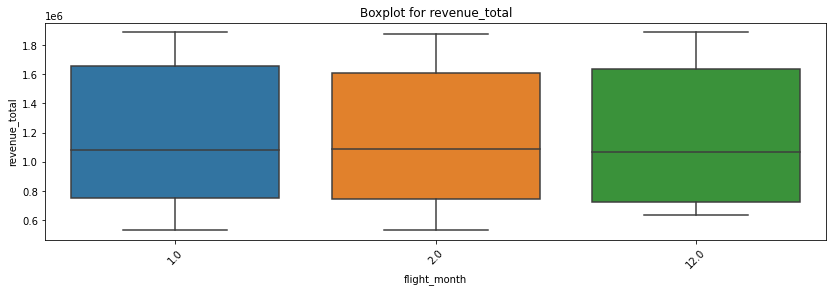

In [50]:
# распределение выручки по месяцам
get_boxplot('flight_month', 'revenue_total', data=data_part)

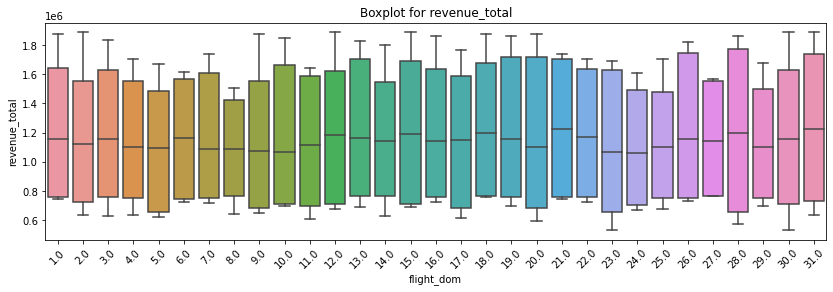

In [51]:
# распределение выручки по дням месяца
get_boxplot('flight_dom', 'revenue_total', data=data_part)

In [52]:
data_part.groupby('flight_dom')['revenue_total'].median().sort_values()

flight_dom
24.0    1061350.0
23.0    1064300.0
10.0    1065700.0
9.0     1072200.0
7.0     1086550.0
8.0     1086550.0
5.0     1094600.0
25.0    1098550.0
29.0    1099950.0
4.0     1101100.0
20.0    1103650.0
11.0    1114850.0
2.0     1122750.0
16.0    1142050.0
27.0    1142650.0
14.0    1142650.0
17.0    1148550.0
1.0     1153650.0
26.0    1154050.0
30.0    1154250.0
19.0    1154850.0
3.0     1157800.0
6.0     1159750.0
13.0    1160950.0
22.0    1166450.0
12.0    1184150.0
15.0    1191450.0
18.0    1196950.0
28.0    1198900.0
21.0    1221950.0
31.0    1227450.0
Name: revenue_total, dtype: float64

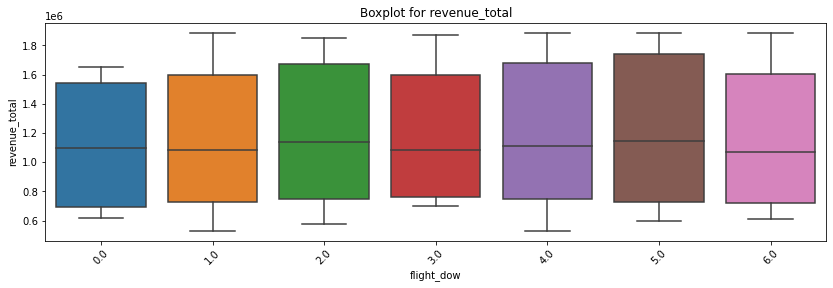

In [53]:
# распределение выручки по дням недели
get_boxplot('flight_dow', 'revenue_total', data=data_part)

In [54]:
data_part.groupby('flight_dow')['revenue_total'].median().sort_values()

flight_dow
6.0    1068850.0
1.0    1081650.0
3.0    1086550.0
0.0    1098150.0
4.0    1111550.0
2.0    1141450.0
5.0    1142650.0
Name: revenue_total, dtype: float64

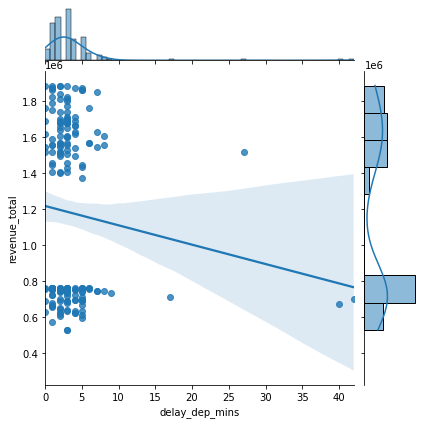

In [55]:
# проверим, зависит ли выручка от фактора задержек вылета
# гипотеза - нет, не зависит
sns.jointplot(x='delay_dep_mins', y='revenue_total',
              data=data_part, kind='reg')

## flight_profit - прибыль рейса (выручка за вычетом расходов)

В подготовленной модели прибыль рейса определяется как разность выручки рейса и сумму расходов, представленных расходами на топливо (зависят от продолжительности рейса), лизинговых платежей (фиксированы для каждого маршрута и оценены приблизительно на основании имеющихся данных о сделках по приобретению самолетов российскими авиакомпаниями) и затрат на бортовое питания для пассажиров (расчитываются от количества проданых билетов на рейс в зависимости от класса билета).

Формула расчета: flight_profit = flight_revenue - (fuel_cost + lease_pay + salary + food_cost)

Рейсы до Москвы оказываются более прибыльными вне зависимости от месяца года, дня месяца и дня недели, чем рейсы до Белгорода. При этом наиболее слабый рейс по прибыли до Москвы в 1.8 раза прибыльнее самого прибылльного рейса до Белгорода.

Самый прибыльный рейс в выборке принес 1438840.0 рублей. Наименее прибыльный - 306665.8 рублей.

In [56]:
# most profitable flights
data_part.sort_values(by='flight_profit', ascending=False)

,flight_id,s_dep,flight_month,flight_dom,flight_dow,s_arr,city_arr,model,fuel_consum_per_h,a_dep,...,revenue_total,flight_profit,flight_margin,profit_per_hour,profit_per_seat,profit_per_passenger,revenue_eco_p,revenue_bus_p,seats_sold_percent,costs_total
3,136474,2016-12-02T10:05:00Z,12.0,2.0,5.0,2016-12-02T11:45:00Z,Moscow,Boeing 737-300,2400,2016-12-02T10:06:00Z,...,1886000.0,1.438840e+06,0.762906,880922.448980,11068.000000,11068.000000,0.767126,0.232874,1.000000,447160.000000
65,136368,2016-12-31T10:05:00Z,12.0,31.0,6.0,2016-12-31T11:45:00Z,Moscow,Boeing 737-300,2400,2016-12-31T10:07:00Z,...,1886000.0,1.435800e+06,0.761294,861480.000000,11044.615385,11044.615385,0.767126,0.232874,1.000000,450200.000000
31,136465,2016-12-15T10:05:00Z,12.0,15.0,4.0,2016-12-15T11:45:00Z,Moscow,Boeing 737-300,2400,2016-12-15T10:05:00Z,...,1886000.0,1.432760e+06,0.759682,842800.000000,11021.230769,11021.230769,0.767126,0.232874,1.000000,453240.000000
18,136273,2016-12-09T10:05:00Z,12.0,9.0,5.0,2016-12-09T11:45:00Z,Moscow,Boeing 737-300,2400,2016-12-09T10:06:00Z,...,1873800.0,1.425645e+06,0.760831,864027.272727,10966.500000,11051.511628,0.765610,0.234390,0.992308,448155.000000
1,136187,2016-12-01T10:05:00Z,12.0,1.0,4.0,2016-12-01T11:45:00Z,Moscow,Boeing 737-300,2400,2016-12-01T10:09:00Z,...,1873800.0,1.424125e+06,0.760020,854475.000000,10954.807692,11039.728682,0.765610,0.234390,0.992308,449675.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,136922,2017-02-11T09:25:00Z,2.0,11.0,6.0,2017-02-11T10:15:00Z,Belgorod,Sukhoi Superjet-100,1700,2017-02-11T09:27:00Z,...,607800.0,3.788375e+05,0.623293,454605.000000,3905.541237,4984.703947,0.689042,0.310958,0.783505,228962.500000
107,136887,2017-01-20T09:25:00Z,1.0,20.0,5.0,2017-01-20T10:15:00Z,Belgorod,Sukhoi Superjet-100,1700,2017-01-20T09:30:00Z,...,595200.0,3.669658e+05,0.616542,449345.918367,3783.152921,4704.690171,0.745968,0.254032,0.804124,228234.166667
191,136844,2017-02-28T09:25:00Z,2.0,28.0,2.0,2017-02-28T10:15:00Z,Belgorod,Sukhoi Superjet-100,1700,2017-02-28T09:26:00Z,...,575100.0,3.514625e+05,0.611133,421755.000000,3623.324742,4448.892405,0.802817,0.197183,0.814433,223637.500000
180,136807,2017-02-23T09:25:00Z,2.0,23.0,4.0,2017-02-23T10:15:00Z,Belgorod,Sukhoi Superjet-100,1700,2017-02-23T09:28:00Z,...,531000.0,3.096875e+05,0.583216,371625.000000,3192.654639,4554.227941,0.715254,0.284746,0.701031,221312.500000


city_arr
Belgorod    AxesSubplot(0.125,0.125;0.775x0.755)
Moscow      AxesSubplot(0.125,0.125;0.775x0.755)
Name: flight_profit, dtype: object

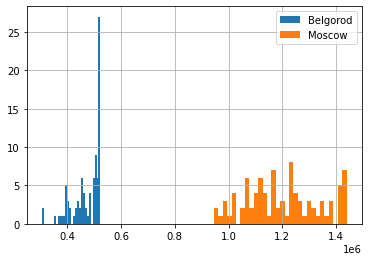

In [57]:
data_part.groupby(by='city_arr')['flight_profit'].hist(bins=30, legend=True)

In [58]:
# least profitable flight to Moscow
least_prof_msc = data_part[data_part['city_arr']
                           == 'Moscow'].flight_profit.min()
least_prof_msc

945600.0

In [59]:
# most profitable flight to Belgorod
most_prof_blg = data_part[data_part['city_arr']
                          == 'Belgorod'].flight_profit.max()
most_prof_blg

523279.16666666657

In [60]:
# diffirence (times)

least_prof_msc / most_prof_blg

1.8070660179795683

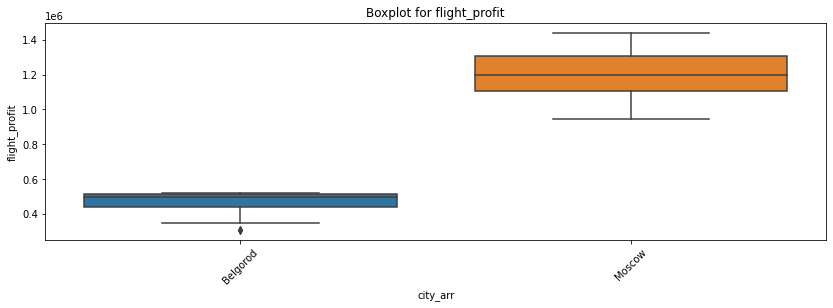

In [61]:
# распределение прибыли рейсов по маршрутам
get_boxplot('city_arr', 'flight_profit', data=data_part)

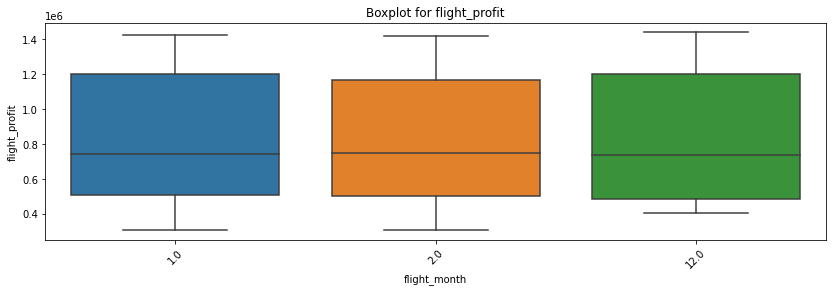

In [62]:
# распределение прибыли рейсов по месяцам
get_boxplot('flight_month', 'flight_profit', data=data_part)

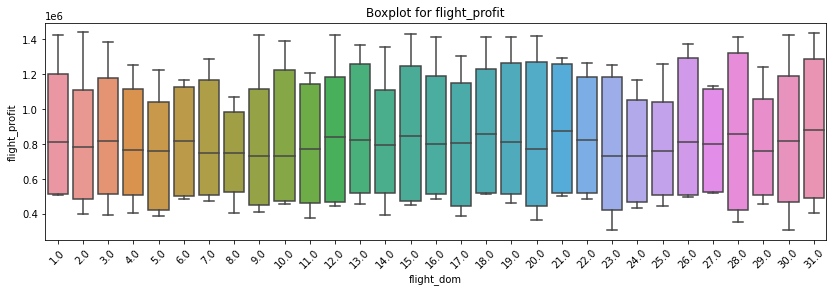

In [63]:
# распределение прибыли рейсов по дням месяца
get_boxplot('flight_dom', 'flight_profit', data=data_part)

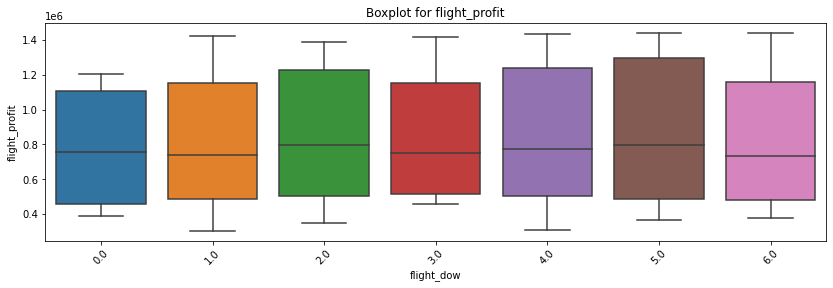

In [64]:
# распределение прибыли рейсов по дням недели
get_boxplot('flight_dow', 'flight_profit', data=data_part)

## flight_margin - рентабельность рейса (отношение прибыли к выручке)

Имея очевидный перевес в пользу рейсов до Москвы стоит оценить относительную эффективность направлений. Сперва оценим рентабельность рейсов. Рентабельность будем оценивать как отношение прибыли к суммарной выручке с рейса.

Разрыв в рентабельности оказывается уже не таким существенным. Так, самый высокорентабельный рейс (Анапа-Москва) показывает рентабельность 76,3% в рамках предложенной модели, а самый низкоэффективный рейс - 57.8%.

И хотя самый маржинальный рейс до Белгорода уступает в рентабельности наименее "слабому" рейсу до Москвы, разница несущественна - 68.4% и 68.7% рентабельности соответственно. На такие рейсы стоит обратить более пристальное внимание при более подробном исследовании.

<AxesSubplot:>

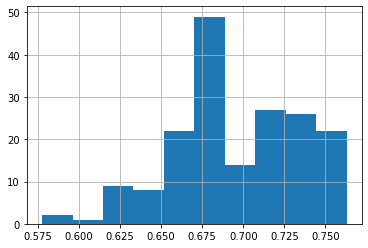

In [65]:
data_part['flight_margin'].hist()

In [66]:
data_part.sort_values(by='flight_margin', ascending=False)

,flight_id,s_dep,flight_month,flight_dom,flight_dow,s_arr,city_arr,model,fuel_consum_per_h,a_dep,...,revenue_total,flight_profit,flight_margin,profit_per_hour,profit_per_seat,profit_per_passenger,revenue_eco_p,revenue_bus_p,seats_sold_percent,costs_total
3,136474,2016-12-02T10:05:00Z,12.0,2.0,5.0,2016-12-02T11:45:00Z,Moscow,Boeing 737-300,2400,2016-12-02T10:06:00Z,...,1886000.0,1.438840e+06,0.762906,880922.448980,11068.000000,11068.000000,0.767126,0.232874,1.000000,447160.000000
65,136368,2016-12-31T10:05:00Z,12.0,31.0,6.0,2016-12-31T11:45:00Z,Moscow,Boeing 737-300,2400,2016-12-31T10:07:00Z,...,1886000.0,1.435800e+06,0.761294,861480.000000,11044.615385,11044.615385,0.767126,0.232874,1.000000,450200.000000
18,136273,2016-12-09T10:05:00Z,12.0,9.0,5.0,2016-12-09T11:45:00Z,Moscow,Boeing 737-300,2400,2016-12-09T10:06:00Z,...,1873800.0,1.425645e+06,0.760831,864027.272727,10966.500000,11051.511628,0.765610,0.234390,0.992308,448155.000000
1,136187,2016-12-01T10:05:00Z,12.0,1.0,4.0,2016-12-01T11:45:00Z,Moscow,Boeing 737-300,2400,2016-12-01T10:09:00Z,...,1873800.0,1.424125e+06,0.760020,854475.000000,10954.807692,11039.728682,0.765610,0.234390,0.992308,449675.000000
31,136465,2016-12-15T10:05:00Z,12.0,15.0,4.0,2016-12-15T11:45:00Z,Moscow,Boeing 737-300,2400,2016-12-15T10:05:00Z,...,1886000.0,1.432760e+06,0.759682,842800.000000,11021.230769,11021.230769,0.767126,0.232874,1.000000,453240.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,136922,2017-02-11T09:25:00Z,2.0,11.0,6.0,2017-02-11T10:15:00Z,Belgorod,Sukhoi Superjet-100,1700,2017-02-11T09:27:00Z,...,607800.0,3.788375e+05,0.623293,454605.000000,3905.541237,4984.703947,0.689042,0.310958,0.783505,228962.500000
107,136887,2017-01-20T09:25:00Z,1.0,20.0,5.0,2017-01-20T10:15:00Z,Belgorod,Sukhoi Superjet-100,1700,2017-01-20T09:30:00Z,...,595200.0,3.669658e+05,0.616542,449345.918367,3783.152921,4704.690171,0.745968,0.254032,0.804124,228234.166667
191,136844,2017-02-28T09:25:00Z,2.0,28.0,2.0,2017-02-28T10:15:00Z,Belgorod,Sukhoi Superjet-100,1700,2017-02-28T09:26:00Z,...,575100.0,3.514625e+05,0.611133,421755.000000,3623.324742,4448.892405,0.802817,0.197183,0.814433,223637.500000
180,136807,2017-02-23T09:25:00Z,2.0,23.0,4.0,2017-02-23T10:15:00Z,Belgorod,Sukhoi Superjet-100,1700,2017-02-23T09:28:00Z,...,531000.0,3.096875e+05,0.583216,371625.000000,3192.654639,4554.227941,0.715254,0.284746,0.701031,221312.500000


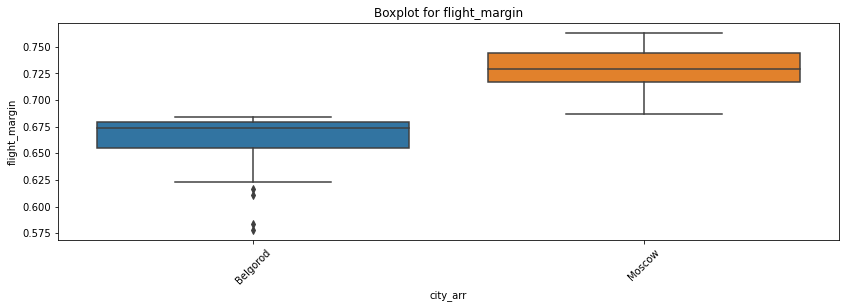

In [67]:
get_boxplot('city_arr', 'flight_margin', data=data_part)

In [68]:
# find more marginable flight to Belgorod than to Moscow
# least marg flight to Moscow
least_marg_msc = data_part[data_part['city_arr']
                           == 'Moscow'].flight_margin.min()
# most marg flight to Belgorod
most_marg_blg = data_part[data_part['city_arr']
                          == 'Belgorod'].flight_margin.max()

print('msc =', least_marg_msc, 'blg =', most_marg_blg)

msc = 0.6868204577968526 blg = 0.6837569144997604


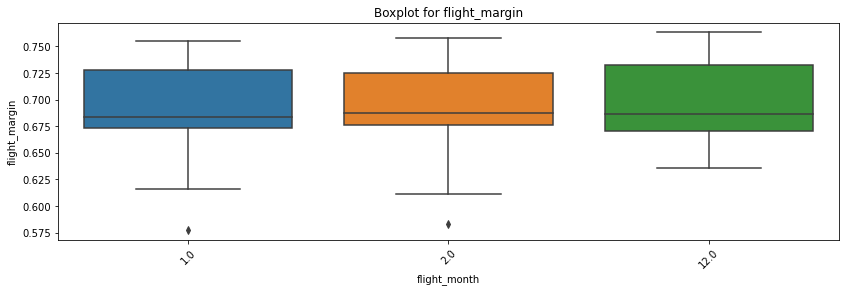

In [69]:
get_boxplot('flight_month', 'flight_margin', data=data_part)

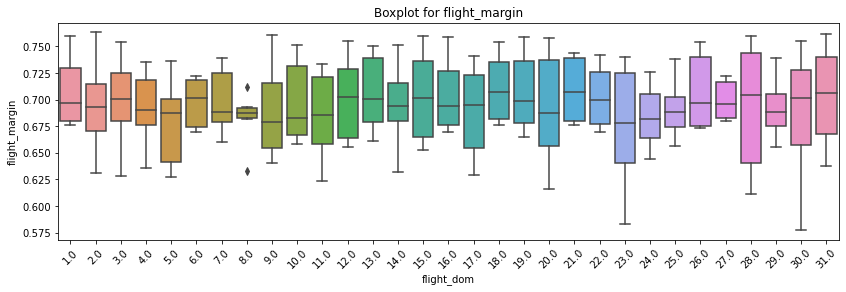

In [70]:
get_boxplot('flight_dom', 'flight_margin', data=data_part)

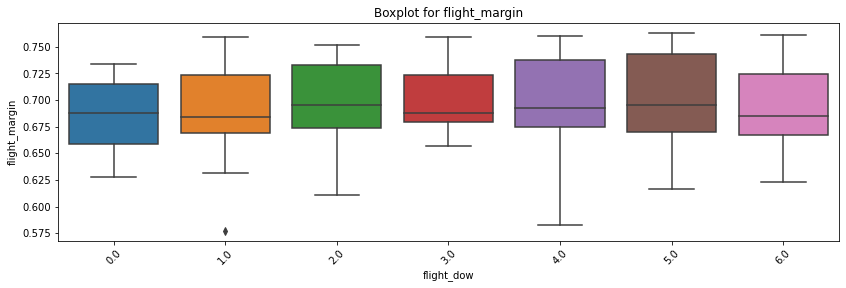

In [71]:
get_boxplot('flight_dow', 'flight_margin', data=data_part)

## profit_per_hour - прибыль в пересчете на 1 час полета

Очень важно! Если мы пересчитаем прибыль рейсов из расчета 1 часа полета, то мы получим 56 (из 90) рейсов Анапа-Белгород, которые окажутся более прибыльными, чем наименее прибыльный рейс Анапа-Москва. Да, необходимо помнить, что средняя прибыль даже при таком "щадящем" пересчете для рейсов Анапа-Белгород, все также в 1.27 раза меньше на указанном направлении.

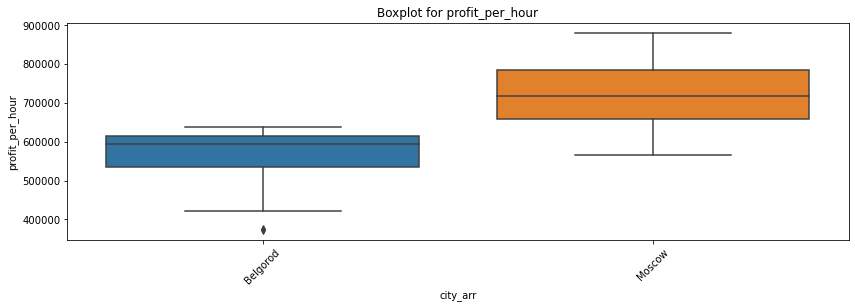

In [72]:
get_boxplot('city_arr', 'profit_per_hour', data=data_part)

In [73]:
# find more marginable flight to Belgorod than to Moscow (re-countable in hours)
# least marg flight to Moscow
least_marg_msc_h = data_part[data_part['city_arr']
                             == 'Moscow'].profit_per_hour.min()
# up-average marg flight to Belgorod
most_marg_blg_h = data_part[data_part['city_arr']
                            == 'Belgorod'].flight_margin.mean()

pay_attention_blg = data_part[(data_part.flight_margin >= most_marg_blg_h)
                              & (data_part.city_arr == 'Belgorod')]

len(pay_attention_blg)

56

In [74]:
# difference in averages

marg_diff_h = data_part[data_part['city_arr'] == 'Moscow'].profit_per_hour.mean(
) / data_part[data_part['city_arr'] == 'Belgorod'].profit_per_hour.mean()

marg_diff_h

1.2712940067923835

## profit_per_seat - прибыль в пересчете на 1 посадочное место

Прибыльность маршрутов не оказывается чувствительной к размеру самолета. Имеем всю ту же разницу в ~2 раза между рейсами на Москву, осуществляемыми на "Боингах", и рейсами на Белгород, которые выполняются "Сухими".

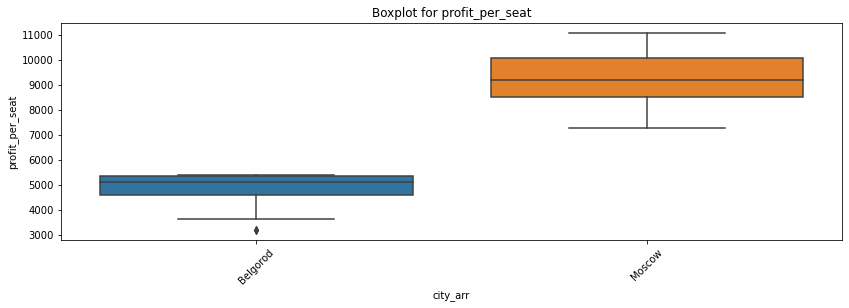

In [75]:
get_boxplot('city_arr', 'profit_per_seat', data=data_part)

## profit_per_passenger - прибыль в пересчете на 1 пассажира

Как и в предыдущем показателя - никаких новых инсайтов о влиянии имеющихся показателей в выгрузке на результирующий - прибыль с рейса.. Количество проданных билетов и прибыль с пассажира все также куда больше зависит от выбранного направления.

Выдвинем гипотезу: получать сопоставимые прибыли с направления Анапа-Белгород можно будет, если при сохранении регулярности рейса изменить парк самолетов, которыми выполняются эти рейсы, увеличив число посадочных мест и тем самым увеличив маржинальность одного полета. Здесь, однако, необходимо проводить дополнительные маркетинговые исследования и изучать спрос - будет ли его достаточно, чтоб самолеты летали с загруженностью на уровне рейсов Анапа-Москва.

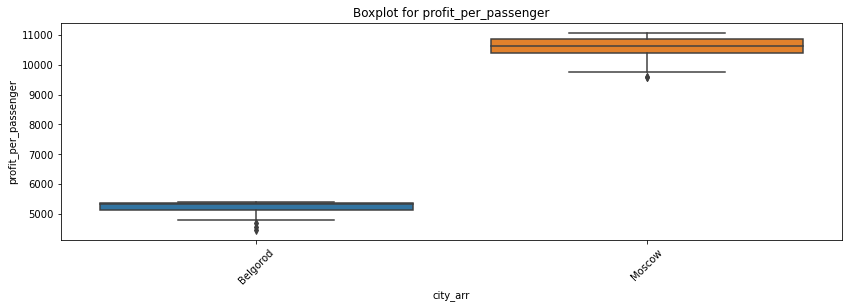

In [76]:
get_boxplot('city_arr', 'profit_per_passenger', data=data_part)

## Корреляционный анализ

Для построения матрицы корреляции сначала выберем из датасета только количественные признаки, отсеяв ординальные и номинативные.

По матрице корреляций очевидна мультиколлинеарность - целый ряд признаков используются в модели расчета прибыльности рейсов. Также есть такие переменные, например, как fuel_consum_per_h, flight_time_h, fuel_cost - все они связаны с вычислением расхода топлива; или, например, total_seats_sold, revenue_eco, revenue_bus, revenue_total - выручка рейса зависит от количества проданных билетов, а суммарная выручка - зависит от выручек классов эконом и бизнес.

In [77]:
# проведем корреляционный анализ всего датасета
data_part_numeric = data_part[['fuel_consum_per_h', 'delay_dep_mins', 'delay_arr_mins', 'flight_time_h', 'fuel_cost', 'lease_pay', 'salary', 'food_cost',
                               'seats_eco', 'total_seats_sold', 'revenue_eco', 'revenue_bus', 'revenue_total', 'flight_margin', 'profit_per_hour', 'profit_per_seat', 'profit_per_passenger']]
correlation = data_part_numeric.corr()

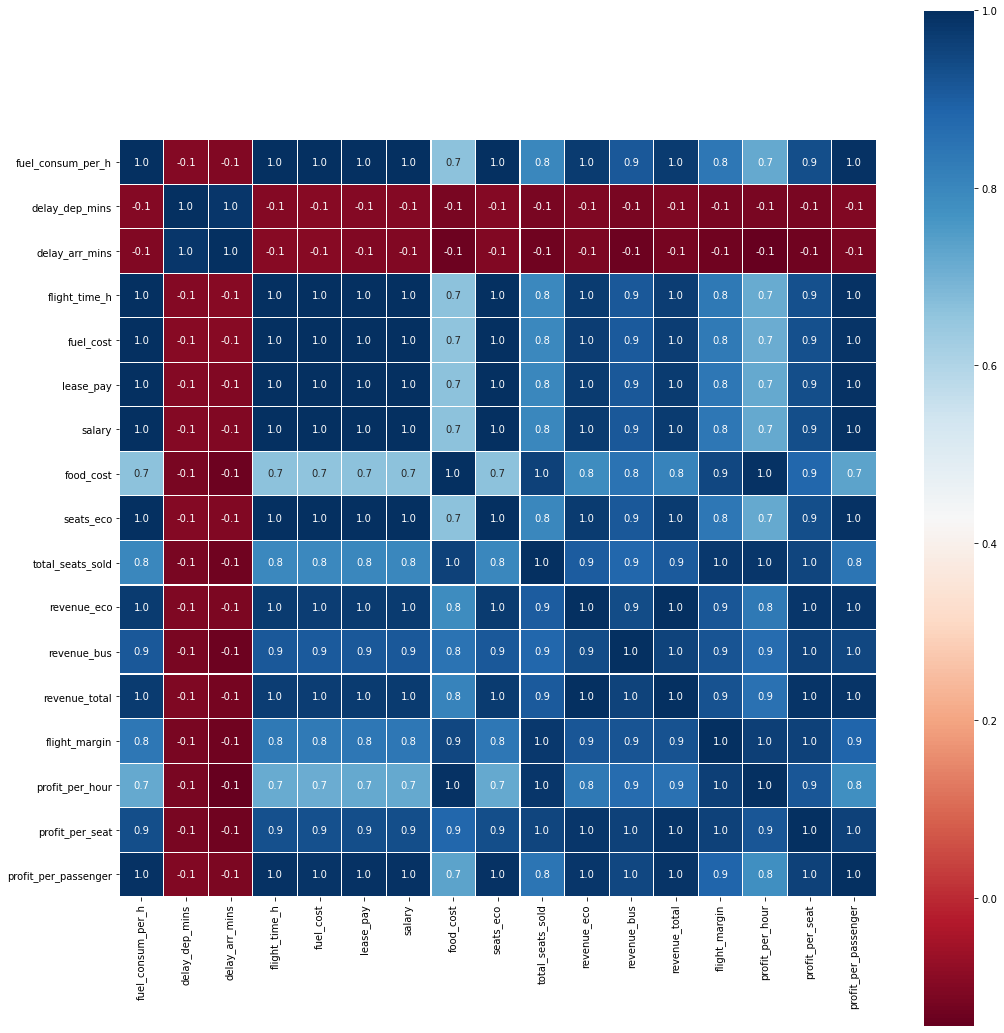

In [78]:
plt.rcParams['figure.figsize'] = (15, 15)
sns.heatmap(correlation, square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")
plt.tight_layout()

## Тестирование номинативных переменных



In [79]:
# определим функция для т-тестирования номинативных признаков
# тестирование проводим в отношении к результирующей переменной flight_profit
def get_stat_dif(column, df):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'flight_profit'],
                     df.loc[df.loc[:, column] == comb[1], 'flight_profit']).pvalue \
                <= 0.1/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [80]:
data.columns

Index(['flight_id', 's_dep', 'flight_month', 'flight_dom', 'flight_dow',
       's_arr', 'city_arr', 'model', 'fuel_consum_per_h', 'a_dep', 'a_arr',
       'delay_dep_mins', 'delay_arr_mins', 'flight_time_h', 'fuel_cost',
       'lease_pay', 'salary', 'food_cost', 'total_seats', 'seats_eco',
       'seats_bus', 'total_seats_sold', 'revenue_eco', 'revenue_bus',
       'revenue_total', 'flight_profit', 'flight_margin', 'profit_per_hour',
       'profit_per_seat', 'profit_per_passenger', 'revenue_eco_p',
       'revenue_bus_p', 'seats_sold_percent', 'costs_total'],
      dtype='object')

In [81]:
for col in ['flight_month', 'flight_dom', 'flight_dow', 'city_arr', 'model']:
    get_stat_dif(col, data_part)

Найдены статистически значимые различия для колонки city_arr
Найдены статистически значимые различия для колонки model


## Оставляем в датасете только оказывающие влияние на результирующую переменную flight_profit количественные и номинативные признаки

Сформируем датасет для дальнейшего моделирования, включив в них те признаки, на которые стоит обратить пристальное внимание в дальнейшей работе.

В наборе данных для моделирования оставим все количественные признаки, выраженные в ходе построения выгрузки, за исключением признаков, которые использовались для их расчетов. Из номинативных признаков оставим только признаки, показавшие свою значимость в результате т-тестирования.

В данном случае в качестве целевого признака мы используем flight_profit - в то же время, таким признаком могут быть, например, flight_margin или profit_per_passenger в зависимости от задач исследования.

In [82]:
data_for_model = data.loc[:, ['flight_id', 'flight_profit', 'city_arr', 'model', 'fuel_cost',
                              'lease_pay', 'salary', 'food_cost', 'seats_eco', 'seats_bus', 'revenue_eco', 'revenue_bus']]
data_for_model.head()

,flight_id,flight_profit,city_arr,model,fuel_cost,lease_pay,salary,food_cost,seats_eco,seats_bus,revenue_eco,revenue_bus
0,136698,5.070308e+05,Belgorod,Sukhoi Superjet-100,52756.666667,96500,20062.5,70050,85,12,519600.0,226800.0
1,136187,1.424125e+06,Moscow,Boeing 737-300,152000.000000,182500,26750.0,88425,118,12,1434600.0,439200.0
2,136774,5.001792e+05,Belgorod,Sukhoi Superjet-100,53833.333333,96500,20062.5,69525,85,12,513300.0,226800.0
3,136474,1.438840e+06,Moscow,Boeing 737-300,148960.000000,182500,26750.0,88950,118,12,1446800.0,439200.0
4,136873,5.164275e+05,Belgorod,Sukhoi Superjet-100,54910.000000,96500,20062.5,71100,85,12,532200.0,226800.0


# Выводы

В наборе данных - информация о 193 рейсах, совершенных из аэропорта Анапы за зимний сезон (с 1 декабря 2016 года по 28 февраля 2017 года).

Рейсы регулярные и равномерно распределены по месяцам, дням месяца и дням недели (однако, во вторник совершено на 13 рейсов больше, чем в остальные дни - рейсы из Анапы в Москву и Белгород осуществляются ежедневно, а еженедельные рейсы - Анапа-Новокузнецк). Рейсы из Анапы за анализируемый период осуществляются на двух моделях самолетов - Boeing 737-300 и Sukhoi Superjet-100 - "Боинг" используется на рейсах до Москвы и Новокузнецка, "Сухой" - на рейсах до Белгорода.

Расписание вылетов соблюдается. Среднее время задержки рейса при вылете - 3.5 минуты. Медиана - 3 минуты. 11 самолетов вылетели из Анапы ровно в назначенное время. Всего в 4 рейсах из 193 задержка вылета составила 10 минут и более. Максимальное опоздание - 42 минуты. Расписание соблюдалось более строго в декабре, если говорить о месяцах; в субботу - если говорить о днях недели. Задержки рейсов не оказывают влияния на прибыльность рейсов.

Минимальное время полета - 0.82 часа (Анапа-Белгород), максимальное - 5.2 часа (Анапа-Новокузнецк). Продолжительности рейсов по трем направлениям в целом распределены нормально и варьируются в следующих диапазонах: Анапа-Белгород от 0.82 до 0.85 часа, Анапа-Москва от 1.63 до 1.72 часа, Анапа-Новокузнецк от 4.98 до 5.2 часа.

В предложенной модели расходы на совершение рейса представлены следующими признаками:
* расход топлива - зависит от двух переменных - расхода топлива конкретной модели самолета в соответствии с документамией (fuel_consum_per_h) и продолжительностью полета;
* лизинговые платежи - перерасчет сумм по лизинговым договорам российских авиакомпаний на приобретение аналогичных моделей самолетов (из открытых источников) в соответствии с относительным времени эксплуатации самолетов в течение суток;
* зарплата экипажа - исходя из маршрутов (ближнемагистральные и среднемагистральные рейсы), продолжительности рейса и время отдыха между рейсами (пересчет на продолжительность рабочего дня) с учетом 20 рабочих жней в месяце и с использованием данных о средней заработной плате работников авиационной отрасли;
* стоимость питания для пассажиров - допущения, используемые в расчетной модели: в среднем, стоимость одного набора питания на пассажира 7-8 долларов (525 рублей) для эконома, для бизнеса и первого класса 30-50 долларов (2250 рублей).

На рейсах Анапа-Новокузнецк нет ни одного проданного билета - ни один пассажир ни разу не воспользовался этим рейсом (технический рейс для удержания "слота"). Использование разных самолетов на рейсах в Москву и Белгород создает неравные условия для конкуренции в размере выручки. Полеты в Москву оказываются более эффективными -  они приносят значительно больше денег. Так, например, самый "горячий" рейс до Белгорода принес компании 765,3 тыс. рублей, при этом самый "низкий" по выручке рейс до Москвы - 1372,4 тыс. рублей. Суммарная выручка со всех рейсов в Москву оказалась в 2.31 раза больше всей выручки рейсов Анапа-Белгород.

В подготовленной модели прибыль рейса определяется как разность выручки рейса и суммы расходов: flight_profit = flight_revenue - (fuel_cost + lease_pay + salary + food_cost). Рейсы до Москвы оказываются более прибыльными вне зависимости от месяца года, дня месяца и дня недели, чем рейсы до Белгорода. При этом наиболее слабый рейс по прибыли до Москвы в 1.8 раза прибыльнее самого прибылльного рейса до Белгорода. Самый прибыльный рейс в выборке принес 1438840.0 рублей. Наименее прибыльный - 306665.8 рублей.

Разрыв в рентабельности оказывается уже не таким существенным. Так, самый высокорентабельный рейс (Анапа-Москва) показывает рентабельность 76,3% в рамках предложенной модели, а самый низкоэффективный рейс - 57.8%. И хотя самый маржинальный рейс до Белгорода уступает в рентабельности наименее "слабому" рейсу до Москвы, разница несущественна - 68.4% и 68.7% рентабельности соответственно.

Если мы пересчитаем прибыль рейсов из расчета 1 часа полета, то мы получим 56 (из 90) рейсов Анапа-Белгород, которые окажутся более прибыльными, чем наименее прибыльный рейс Анапа-Москва. Необходимо помнить, что средняя прибыль даже при таком "щадящем" пересчете для рейсов Анапа-Белгород все еще в 1.27 раза меньше.

Гипотеза: получать сопоставимые прибыли с направления Анапа-Белгород возможно при сохранении регулярности рейса и замене парка самолетов, которыми выполняются эти рейсы. Увеличив число посадочных мест - увеличим маржинальность одного полета. Здесь, однако, необходимо проводить дополнительные маркетинговые исследования и изучать спрос - будет ли его достаточно, чтоб самолеты летали с загруженностью на уровне рейсов Анапа-Москва.

Т-тестирование Стьюдента для номинативных признаков показало значимость двух из них - маршрут и модель самолета.

# Дополнительное задание *

Мы успешно представили данные и возможные решения центральному руководству, но решение проблемы было отложено на следующий квартал, а наш филиал хочет оптимизировать полеты уже этой зимой.

Мой босс попросил самостоятельно принять решение о том, какие рейсы зимнего периода мы исключаем.

## Задачи:
1. Указать номера рейсов, которые предлагается убрать.

Не имея информации о стоимости слота Анапа-Новокузнецк, мы не можем принимать решение об отказа от этих рейсов.  
Анализировать будем рейсы Анапа-Москва и Анапа-Белгород.

Для принятия решения об отказе от тех или иных рейсов целесообразно построить прогностическую модель и, учитывая ее оценки, а также мнение экспертов, убирать из расписания рейсы в соответствии с заданным критерием.

Номера рейсов для исключения - 136642, 136807. Это рейсы Анапа-Белгород - 30 января 2017 года (понедельник) и 23 февраля 2017 года (четверг).

2. Указать предполагаемую прибыльность этих рейсов и среднюю прибыльность всех рейсов.

Прибыльность рейсов, подлежащих закрытию: 375509.2, 371625.0  
Средняя прибыльность всех рейсов в пересчете на час полета: 645053.4
    
3. Описать, как проводилась аналитика, какие данные были использованы для оценки доходности рейса и расходов на них.

Для оценки необходимости закрытия рейсов использовался сгенерированный показатель profit_per_hour - прибыль рейса в пересчете на час полета. Показатель выражается как отношение flight_profit (прибыль рейса) к продолжительности рейса (в часах). Прибыль, в свою очередь, представлена в финансовой модели как разность выручки с рейса (revenue_total - сумма денежных средств, полученная от продажи билетов) и расходов: стоимость топлива, лизинговый платеж, заработная плата экипажа, стоимость питания для пассажиров.

Для выбора рейсов были оценены межквартильные интервалы в распределении profit_per_hour и указаны рейсы, прибыль которых оказалась ниже границы отсечения (quantile0.25 - 1.5*IQR).

In [83]:
# оценим межквартильный размах и выберем из датасета рейсы,
# для которых profit_per_hour < нижней границы межквартильного интервала

flights_msc = data_part.loc[data_part['city_arr'] == 'Moscow']
flights_blg = data_part.loc[data_part['city_arr'] == 'Belgorod']

IQR = flights_msc.profit_per_hour.quantile(
    0.75) - flights_msc.profit_per_hour.quantile(0.25)
perc25 = flights_msc.profit_per_hour.quantile(0.25)

flights_to_remove_msc = flights_msc.loc[flights_msc['profit_per_hour'] < (
    perc25 - 1.5*IQR)]

IQR = flights_blg.profit_per_hour.quantile(
    0.75) - flights_blg.profit_per_hour.quantile(0.25)
perc25 = flights_blg.profit_per_hour.quantile(0.25)

flights_to_remove_blg = flights_blg.loc[flights_blg['profit_per_hour'] < (
    perc25 - 1.5*IQR)]

In [84]:
flights_to_remove_msc

,flight_id,s_dep,flight_month,flight_dom,flight_dow,s_arr,city_arr,model,fuel_consum_per_h,a_dep,...,revenue_total,flight_profit,flight_margin,profit_per_hour,profit_per_seat,profit_per_passenger,revenue_eco_p,revenue_bus_p,seats_sold_percent,costs_total


In [85]:
flights_to_remove_blg

,flight_id,s_dep,flight_month,flight_dom,flight_dow,s_arr,city_arr,model,fuel_consum_per_h,a_dep,...,revenue_total,flight_profit,flight_margin,profit_per_hour,profit_per_seat,profit_per_passenger,revenue_eco_p,revenue_bus_p,seats_sold_percent,costs_total
128,136642,2017-01-30T09:25:00Z,1.0,30.0,1.0,2017-01-30T10:15:00Z,Belgorod,Sukhoi Superjet-100,1700,2017-01-30T09:28:00Z,...,531000.0,306665.833333,0.577525,375509.183673,3161.503436,4791.653646,0.644068,0.355932,0.659794,224334.166667
180,136807,2017-02-23T09:25:00Z,2.0,23.0,4.0,2017-02-23T10:15:00Z,Belgorod,Sukhoi Superjet-100,1700,2017-02-23T09:28:00Z,...,531000.0,309687.500000,0.583216,371625.000000,3192.654639,4554.227941,0.715254,0.284746,0.701031,221312.500000


In [86]:
print('Прибыльность рейсов, подлежащих закрытию:')
display(flights_to_remove_blg.profit_per_hour)
print('Средняя прибыльность всех рейсов в пересчете на час полета')
display(data_part.profit_per_hour.mean())

Прибыльность рейсов, подлежащих закрытию:


128    375509.183673
180    371625.000000
Name: profit_per_hour, dtype: float64

Средняя прибыльность всех рейсов в пересчете на час полета


645053.3507449763

# Итоговый доклад

Презентация - https://docs.google.com/presentation/d/1jC4JbgObW0D_q-YQyVd3kQM1zawkKjLD6RyEnrHtLpo/edit?usp=sharing